In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import json
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
from PIL import Image

In [3]:
# CONSTANTS
BATCH_SIZE = 32
NUM_FOLDS = 5
NUM_EPOCHS = 10
NUM_WORKERS = 8

## EDA

In [4]:
with open("./data/label_num_to_disease_map.json") as label_mapping_file:
    label_map = json.load(label_mapping_file)

In [5]:
df_train_img_names = pd.read_csv("./data/train.csv")
# Add a column with disease name
df_train_img_names["disease"] = df_train_img_names.apply(
    lambda row: label_map[str(row["label"])], axis=1
    )
df_train_img_names.head()

,image_id,label,disease
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [6]:
df_train_img_names.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

Check the disease distribution within the training samples. Distribution doesn't seem balanced with CMD outnumbering other disease types by a wide margin

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: disease, dtype: int64


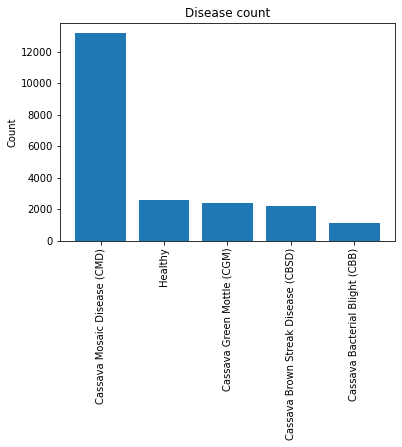

In [7]:
# Disease distribution
disease_counts = df_train_img_names.disease.value_counts()
print(disease_counts)
plt.bar(disease_counts.index, disease_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Disease count")
plt.show()


In [8]:

# split the training dataframe into kfolds for cross validation. We do this before any processing is done
# on the data. We use stratified kfold if the target distribution is unbalanced
def strat_kfold_dataframe(df, target_col_name, num_folds=5):
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # randomize of shuffle the rows of dataframe before splitting is done
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    # get the target data
    y = df[target_col_name].values
    skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X=df, y=y)):
        df.loc[val_index, "kfold"] = fold    
    return df     

df_train_img_names = strat_kfold_dataframe(df_train_img_names, target_col_name="label")
df_train_img_names.head()

,image_id,label,disease,kfold
0,2615227158.jpg,4,Healthy,2
1,1277648239.jpg,3,Cassava Mosaic Disease (CMD),1
2,2305895487.jpg,3,Cassava Mosaic Disease (CMD),2
3,336299725.jpg,2,Cassava Green Mottle (CGM),1
4,1951270318.jpg,2,Cassava Green Mottle (CGM),0


In [9]:
import tqdm

# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html
# https://www.thoughtco.com/sum-of-squares-formula-shortcut-3126266
def get_imgs_mean_stddev(dl_img, axis=None):    
    """Get the mean and standard deviation for images in a dataset / mini-batch.
    img batch is of shape BS * C * H * W 
    where BS = batch_size or no of training samples 
    C = 3 ( RGB channels ), H = height of image matrix, W = width of image matrix
    Args:
        dl_imgs ([DataLoader]): image data loader
        axis ([tuple of ints], optional): Axis along which mean and std dev is to be calculated.
        Defaults to None.
    Returns:
        [tuple]: tuple of tensors with mean and std.dev. of the imgs
    """
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    # sum of pixel values along RGB channels
    psum = torch.Tensor([0.0, 0.0, 0.0])
    # sum of squares of pixel values along RGB channels
    psum_sq = torch.Tensor([0.0, 0.0, 0.0])        
    num_img = 0    
    img_h, img_w = 0, 0    
    count = 0
    for img, label in tqdm.tqdm(dl_img): 
        if count == 0:            
            img_h = img.shape[2]       
            img_w = img.shape[3]
        num_img += img.shape[0]            
        psum += img.sum(axis=[0, 2, 3])        
        img_sq = img.square()
        psum_sq += img_sq.sum(axis=[0, 2, 3])
        count += 1
    # pixel count of single img (index 1 is the height and index 2 is width of img)
    img_pixel_count = img_h * img_w      
    total_pixel_count = num_img * img_pixel_count   
    # mean of pixel values across the dataset        
    total_mean = psum / total_pixel_count    
    # variance of pixel values across the dataset
    total_var = (psum_sq / total_pixel_count) - (total_mean.square())    
    total_std = torch.sqrt(total_var)
    return total_mean, total_std

# Define a custom pytorch Dataset for training

In [10]:
# A dataset contains the logic to fetch, load and if required transform data to bring it to a format
# that can be used by dataloaders for training
class CassavaImageDataset(Dataset):
    def __init__(self, df, img_name_col, target_col, img_root_folder, transform=None, target_transform=None):
        self.df = df
        self.img_name_col = img_name_col
        self.target_col = target_col
        self.img_root_folder = img_root_folder
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_path = self.img_root_folder + "/" + self.df.loc[index, self.img_name_col]
        img = Image.open(img_path)
        img_label = self.df.loc[index, self.target_col]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            img_label = self.target_transform(img_label)
        return img, img_label

    def __len__(self):
        return len(self.df)

In [11]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.4303, 0.4967, 0.3135], [0.2203, 0.2232, 0.2114])
])

val_transform = transforms.Compose([
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),        
        transforms.Normalize([0.4303, 0.4967, 0.3135], [0.2203, 0.2232, 0.2114])
])

In [12]:
def get_fold_dls(fold, df_imgs):
    df_train = df_imgs[df_imgs["kfold"] != fold].reset_index(drop=True)
    df_val = df_imgs[df_imgs["kfold"] == fold].reset_index(drop=True)    
    ds_train = CassavaImageDataset(
        df_train, 
        img_name_col="image_id",
        target_col="label",
        img_root_folder="./data/train_images", 
        transform=train_transform,
        target_transform=torch.as_tensor
        )
    ds_val = CassavaImageDataset(
        df_val, 
        img_name_col="image_id",
        target_col="label",
        img_root_folder="./data/train_images", 
        transform=val_transform,
        target_transform=torch.as_tensor
        )        
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)    
    dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True)
    return dl_train, dl_val, ds_train, ds_val

In [13]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, df_train_img_names)

In [14]:
len(ds_val)

4280

In [15]:
# counter = 0
# for imgs, lbls in dl_val:
#     if counter > 0:
#         break
#     img_mean = torch.mean(imgs, axis=(0, 2, 3))
#     img_std = torch.std(imgs, axis=(0, 2, 3))
#     counter += 1
# print(img_mean, img_std)    

In [16]:
# ds_all = CassavaImageDataset(
#         df_train_img_names, 
#         img_name_col="image_id",
#         target_col="label",
#         img_root_folder="./data/train_images", 
#         transform=train_transform,
#         target_transform=torch.as_tensor
#         )
# dl_all = DataLoader(ds_all, batch_size=BATCH_SIZE, shuffle=True)            
# img_mean, img_std = get_imgs_mean_stddev(dl_all)
# print(f"img mean calculated on entire training dataset = {img_mean}")
# print(f"img std calculated on entire training dataset = {img_std}")

img mean calculated on entire training dataset = tensor([0.4303, 0.4967, 0.3135])<br>
img std calculated on entire training dataset = tensor([0.2203, 0.2232, 0.2114])

In [17]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(9, 6))
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display
            img = img.transpose(1, 2, 0)
            ax.imshow(Image.fromarray(np.uint8(img)).convert('RGB'))        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

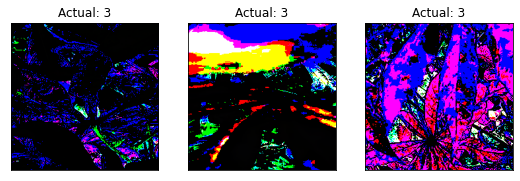

In [18]:
show_batch(ds_val, 3, 1, 3)

In [19]:
from typing import Optional
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, fold, img_root_path, df, img_name_col, target_col, batch_size=BATCH_SIZE,  
                 input_img_dims=(3,224,224),num_target_classes=5, 
                 train_transforms=None, val_transforms=None):  
        super().__init__()                       
        self.fold = fold
        self.img_root_path = img_root_path  
        self.df = df
        self.img_name_col = img_name_col
        self.target_col = target_col
        self.batch_size = batch_size
        self.input_imgs_dims = input_img_dims        
        self.num_target_classes = num_target_classes
        default_transforms = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.4303, 0.4967, 0.3135], [0.2203, 0.2232, 0.2114])
            ])
        if train_transforms is None:
            self.train_transforms = default_transforms
        else:
            self.train_transforms = train_transforms    

        if val_transforms is None:
            self.val_transforms = default_transforms
        else:
            self.val_transforms = val_transforms                        

    def prepare_data(self) -> None:
         return super().prepare_data()       

    def setup(self, stage: Optional[str] = None) -> None:
        super().setup(stage=stage)                     
        self.df_train = self.df[self.df["kfold"] != self.fold].reset_index(drop=True)
        self.df_val = self.df[self.df["kfold"] == self.fold].reset_index(drop=True)  
        self.ds_train = CassavaImageDataset(
            self.df_train, 
            img_name_col=self.img_name_col,
            target_col=self.target_col,
            img_root_folder=self.img_root_path, 
            transform=self.train_transforms,
            target_transform=torch.as_tensor
            )
        self.ds_val = CassavaImageDataset(
            self.df_val, 
            img_name_col=self.img_name_col,
            target_col=self.target_col,
            img_root_folder=self.img_root_path, 
            transform=self.val_transforms,
            target_transform=torch.as_tensor
            )            

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.ds_train, batch_size=self.batch_size, shuffle=True, 
                            num_workers=NUM_WORKERS)            

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.ds_val, batch_size=self.batch_size, num_workers=NUM_WORKERS)            

In [20]:
img_name_col="image_id"
target_col="label"
img_root_folder="./data/train_images"

dm = CassavaDataModule(
    fold = 0, 
    df = df_train_img_names,
    img_root_path = img_root_folder,
    img_name_col = img_name_col,
    target_col = target_col,
    train_transforms = train_transform,
    val_transforms = val_transform
    )

dm.prepare_data()    
dm.setup()

In [37]:
import torchvision.models as models
import torch.nn as nn
import torchmetrics

class ResnetTL_LitModel(pl.LightningModule):
    def __init__(self, num_classes, fine_tune=True, drop_out=0.25, lr=0.00012):
        super().__init__()
        pt_model = models.resnet50(pretrained=True)
        self.num_classes = num_classes
        self.lr = lr
        self.fine_tune = fine_tune
        self.drop_out = drop_out        
        self.train_loss = nn.CrossEntropyLoss()
        self.val_loss = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy() 
        self.val_accuracy = torchmetrics.Accuracy()
        # We cut the head from the pretrained model and use the remaining model as a feature extractor
        pt_layers = list(pt_model.children())[:-1]
        self.backbone = nn.Sequential(*pt_layers)
        # Create a new model head
        # For resnet50 the num of input features to final FC layer is 2048
        self.new_head = self.create_model_head(pt_model.fc.in_features)        

    def create_model_head(self, in_features):         
        # Create a new model head 
        # The weights of the newly created layers are initialized by pytorch automatically
        # See : https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L81
        new_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=self.drop_out),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=self.drop_out),
            nn.Linear(256, self.num_classes)
        )                
        return new_head

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)
        x = self.new_head(features)
        return x

    def configure_optimizers(self):
        model_optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, "min")        
        return {
            "optimizer": model_optimizer, 
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)        
        loss = self.train_loss(y_pred, y)
        acc = self.train_accuracy(y_pred, y)
        self.log("train_loss", loss, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_accuracy", acc, on_epoch=True, logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = self.val_loss(y_pred, y)
        acc = self.val_accuracy(y_pred, y)
        self.log("val_loss", loss, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_accuracy", acc, on_epoch=True, logger=True, prog_bar=True)
        return loss

In [38]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning

cassava_model = ResnetTL_LitModel(num_classes=5, lr=0.00012)
tb_logger = pl.loggers.TensorBoardLogger("logs", "cassava_model")
checkpoint_callback = ModelCheckpoint(dirpath="./model", monitor="val_loss", filename="cassava_best_model")
multiplicative = lambda epoch: 1.5
backbone_finetuning = BackboneFinetuning(5, multiplicative)

trainer = pl.Trainer(
    gpus=1,
    auto_select_gpus=True,
    progress_bar_refresh_rate=20,
    max_epochs=NUM_EPOCHS,
    logger=tb_logger,
    auto_lr_find=True,
    callbacks=[checkpoint_callback, backbone_finetuning]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [33]:
trainer.tune(cassava_model, dm)

{}

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | train_loss     | CrossEntropyLoss | 0     
1 | val_loss       | CrossEntropyLoss | 0     
2 | train_accuracy | Accuracy         | 0     
3 | val_accuracy   | Accuracy         | 0     
4 | backbone       | Sequential       | 23.5 M
5 | new_head       | Sequential       | 1.2 M 
----------------------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
98.759    Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /home/bk_anupam/code/ML/Kaggle/cassava-leaf-disease/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/bk_anupam/code/ML/Kaggle/cassava-leaf-disease/lr_find_temp_model.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

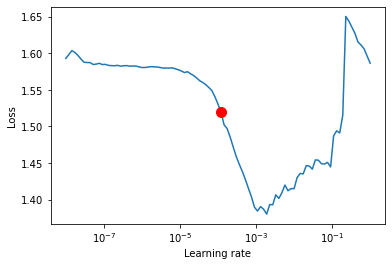

In [34]:
lr_finder = trainer.tuner.lr_find(cassava_model, dm)
print(lr_finder.results)
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [35]:
lr_finder.suggestion()

0.00012022644346174131

In [39]:
trainer.fit(cassava_model, dm)

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | train_loss     | CrossEntropyLoss | 0     
1 | val_loss       | CrossEntropyLoss | 0     
2 | train_accuracy | Accuracy         | 0     
3 | val_accuracy   | Accuracy         | 0     
4 | backbone       | Sequential       | 23.5 M
5 | new_head       | Sequential       | 1.2 M 
----------------------------------------------------
1.2 M     Trainable params
23.5 M    Non-trainable params
24.7 M    Total params
98.759    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [22]:
%load_ext tensorboard